In [108]:
import numpy as np 
import matplotlib.pylab as plt 
from scipy.integrate import odeint
import torch 

from deepymod_torch.library_function import library_ODE,library_1D_in
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.neural_net import train_group, deepmod_init, train_group_mse
from deepymod_torch.sparsity import scaling, threshold
from deepymod_torch.utilities import terms_definition
#try:
#    torch.set_default_tensor_type('torch.cuda.FloatTensor')
#except:
#    pass

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate some ODE data

In [109]:
t = np.linspace(0, 20, 501)

In [110]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*theta]
    return dydt

In [111]:
y0 = [np.pi - 0.1, 0.0]

In [112]:
b, c = 0.5, 2

In [113]:
sol = odeint(pend, y0, t, args=(b, c))

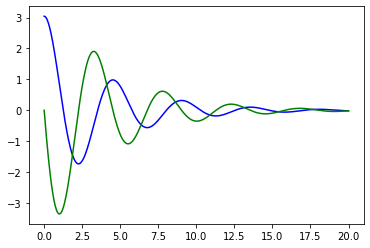

In [114]:
plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1], 'g', label='omega(t)')

In [115]:
y_full = sol
x_full = t.reshape(-1,1)

In [116]:
print(x_full.shape,y_full.shape)

(501, 1) (501, 2)


In [150]:
noise_level = 0.15
y_noisy = y_full + noise_level * np.std(y_full) * np.random.randn(y_full.shape[0],y_full.shape[1])

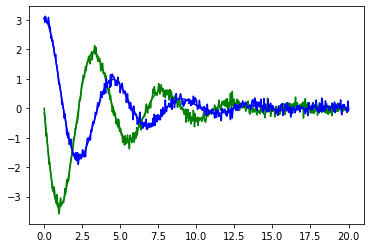

In [151]:
plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1], 'g', label='omega(t)')
plt.plot(t, y_noisy[:, 1], 'g', label='omega(t)')
plt.plot(t, y_noisy[:, 0], 'b', label='omega(t)')

# DeepMoD

In [152]:
num_samples = 500
rand_idx = np.random.permutation(x_full.shape[0])[:num_samples]

X_train = torch.tensor(x_full[rand_idx, :], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[rand_idx, :], dtype=torch.float32, requires_grad=True)

In [153]:
network_config = {'input_dim': 1, 'hidden_dim': 20, 'layers': 3, 'output_dim': y_train.shape[1]}
optim_config = {'lambda': 10**-6, 'max_iterations': 10001}
library_config = {'type': library_ODE, 'poly_order': 2, 'diff_order': 0}

In [154]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, library_config)

In [155]:
train_group_mse(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 1.5E+00 1.5E+00
5000 2.9E-02 2.9E-02
10000 3.2E-02 3.2E-02


In [156]:
time_deriv_list, theta, coeff_vector_list = train_group(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 5.7E+01 3.0E-02 5.7E+01 1.6E-05 1.9E-05
tensor([[-2.3770],
        [ 0.4123],
        [ 0.0334],
        [ 0.3492],
        [ 0.1904],
        [ 0.1403],
        [-2.0640],
        [ 1.1762],
        [ 0.0940]], requires_grad=True)
tensor([[ 0.2998],
        [-0.1303],
        [-0.7385],
        [-3.0235],
        [ 0.1064],
        [-1.1062],
        [ 0.3708],
        [ 0.8095],
        [ 0.3848]], requires_grad=True)
2500 2.3E-01 1.8E-01 5.3E-02 7.7E-06 1.0E-05
tensor([[-0.2507],
        [ 1.0835],
        [ 0.3345],
        [ 1.7236],
        [ 0.3569],
        [-0.0498],
        [-0.9194],
        [ 1.0053],
        [ 0.2243]], requires_grad=True)
tensor([[ 0.4513],
        [-1.8757],
        [-0.0768],
        [-2.6990],
        [ 0.9803],
        [-0.6677],
        [ 0.4915],
        [ 0.7052],
        [ 0.3510]], requires_grad=True)
5000 3.2E-02 3.2E-02 7.4E-04 4.1E-06 5.3E-06
tensor([[ 0.0168],
        [ 1.0188],
        [-0.0351],
       

In [147]:
scaled_coeff_vector_list = [scaling(coeff_vector, theta, time_deriv) for coeff_vector, theta , time_deriv in zip(coeff_vector_list, theta, time_deriv_list)]

In [148]:
sparse_coeff_vector_list, sparsity_mask_list = zip(*[threshold(scaled_coeff_vector, coeff_vector) for scaled_coeff_vector, coeff_vector in zip(scaled_coeff_vector_list, coeff_vector_list)])

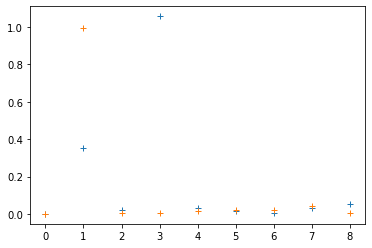

In [149]:
plt.plot(np.abs(scaled_coeff_vector_list[1].detach().numpy()),'+')
plt.plot(np.abs(scaled_coeff_vector_list[0].detach().numpy()),'+')

In [127]:
sparsity_mask_list

(tensor([1]), tensor([3]))

In [100]:
X_all = torch.tensor(x_full, dtype=torch.float32, requires_grad=True) 
prediction_full = network(X_all).cpu()

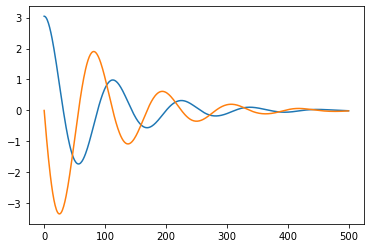

In [101]:
plt.plot(prediction_full[:,0].detach().numpy())
plt.plot(prediction_full[:,1].detach().numpy())

In [198]:
poly_list = [['','u'], ['','v'], ['', 'w']]
deriv_list = [['', 'u_x'], ['', 'v_x'], ['', 'w_x']]

In [20]:
from itertools import product, chain
from functools import reduce

In [21]:
def string_matmul(list_1, list_2):
    prod = [element[0] + element[1] for element in product(list_1, list_2)]
    return prod

In [22]:
poly_list

[['', 'u'], ['', 'v'], ['', 'w']]

In [23]:
theta_uv = reduce((lambda x, y: string_matmul(x, y)), poly_list)
theta_uv

['', 'w', 'v', 'vw', 'u', 'uw', 'uv', 'uvw']

In [157]:
a = torch.arange(4).reshape(2, 2)
b = torch.arange(4).reshape(2, 2)
my_list = [a, b,a,b]
my_list

[tensor([[0, 1],
         [2, 3]]), tensor([[0, 1],
         [2, 3]]), tensor([[0, 1],
         [2, 3]]), tensor([[0, 1],
         [2, 3]])]

In [161]:
my_list[0][:,0]

tensor([0, 2])

In [ ]:
def string_matmul(list_1, list_2):
    prod = [element[0] + element[1] for element in product(list_1, list_2)]
    return prod

In [122]:
test = [torch.tensor([(0,1)], dtype=torch.float32, requires_grad=True),torch.tensor([(0,1)], dtype=torch.float32, requires_grad=True),torch.tensor([(0,1)], dtype=torch.float32, requires_grad=True)]

In [162]:
test = torch.tensor([((0,1),(0,1)),((0,1),(0,1)),((0,1),(0,1))], dtype=torch.float32, requires_grad=True)
test

tensor([[[0., 1.],
         [0., 1.]],

        [[0., 1.],
         [0., 1.]],

        [[0., 1.],
         [0., 1.]]], requires_grad=True)

In [132]:
poly_test=[tensor([[ 1.0000, -0.3377],
        [ 1.0000, -0.3450],
        [ 1.0000, -0.3612],
        [ 1.0000, -0.3481],
        [ 1.0000, -0.3730]]), tensor([[ 1.0000, -0.3413],
        [ 1.0000, -0.3395],
        [ 1.0000, -0.3323],
        [ 1.0000, -0.3385],
        [ 1.0000, -0.3204]]), tensor([[ 1.0000, -0.4954],
        [ 1.0000, -0.4939],
        [ 1.0000, -0.4874],
        [ 1.0000, -0.4931],
        [ 1.0000, -0.4765]])]

NameError: name 'tensor' is not defined

In [126]:
reduce((lambda x, y: string_matmul(x, y)), test)

[tensor([0., 3.], grad_fn=<AddBackward0>)]

In [108]:
uv_list = torch.cat([x.float() for x in test], dim=1)

In [104]:
torch.matmul(uv_list,uv_list)

RuntimeError: size mismatch, m1: [3 x 2], m2: [3 x 2] at ../aten/src/TH/generic/THTensorMath.cpp:197

probleem is dat polylist een lijst van tensoren is! 

In [59]:
theta_uv = reduce((lambda x, y: string_matmul(x, y)), new_test)
torch.tensor(theta_uv).view(1,-1)

tensor([[0., 1., 1., 2., 1., 2., 2., 3.]])

In [378]:
test = torch.tensor([(0,1,2),(0,1,2)], dtype=torch.float32, requires_grad=True)

In [339]:
torch.matmul(test[0],test[1])

tensor(2., grad_fn=<DotBackward>)

In [338]:
torch.cat([torch.matmul(u[:, :, None], v[:, None, :]) for u, v in combinations(test, 2)], 1)

IndexError: too many indices for tensor of dimension 1

In [163]:
poly_list[0]

['', 'u']

In [164]:
combinations(poly_list,2)

In [152]:
theta_dudv = reduce((lambda x, y: string_matmul(x, y)[1:]), deriv_list)
theta_dudv

['v_xw_x', 'u_x', 'u_xw_x', 'u_xv_x', 'u_xv_xw_x']

In [153]:
theta_udv = list(chain.from_iterable([string_matmul(u[1:], dv[1:]) for u, dv in product(poly_list, deriv_list)]))
theta_udv

['uu_x', 'uv_x', 'uw_x', 'vu_x', 'vv_x', 'vw_x', 'wu_x', 'wv_x', 'ww_x']

In [154]:
[element for element in (theta_uv + theta_dudv + theta_udv)]

['',
 'w',
 'v',
 'vw',
 'u',
 'uw',
 'uv',
 'uvw',
 'v_xw_x',
 'u_x',
 'u_xw_x',
 'u_xv_x',
 'u_xv_xw_x',
 'uu_x',
 'uv_x',
 'uw_x',
 'vu_x',
 'vv_x',
 'vw_x',
 'wu_x',
 'wv_x',
 'ww_x']

In [ ]:
def terms_definition(poly_list, deriv_list):
    theta_uv = [string_matmul(u, v) for u, v in combinations(poly_list, 2)]
    theta_dudv = [string_matmul(du, dv)[1:] for du, dv in combinations(deriv_list, 2)]
    theta_udv = [string_matmul(u[1:], dv[1:]) for u, dv in product(poly_list, deriv_list)]
    theta = [element for theta_specific in (theta_uv + theta_dudv + theta_udv) for element in theta_specific]